### Import

In [10]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import tensorflow as tf


In [11]:
train_data = np.load('train_data.npy')
tr_label = np.load('train_label.npy')
test_data = np.load('test_data.npy')
ts_label = np.load('test_label.npy')

print("shape of tran_data is {} and of tran_label is {}".format(train_data.shape, tr_label.shape))
print("shape of test_data is {} and of test_label is {}".format(test_data.shape, ts_label.shape))

data_stats = {
    'Minimum': np.min(train_data),
    'Maximum': np.max(train_data),
    'Mean': np.mean(train_data),
    'Standard Deviation': np.std(train_data),
    "label example" : tr_label[:10]
}

data_stats

shape of tran_data is (50000, 128) and of tran_label is (50000, 1)
shape of test_data is (10000, 128) and of test_label is (10000, 1)


{'Minimum': -23.41520966868848,
 'Maximum': 25.581360537720347,
 'Mean': -1.593740250882547e-14,
 'Standard Deviation': 1.1688636581970187,
 'label example': array([[6],
        [9],
        [9],
        [4],
        [1],
        [1],
        [2],
        [7],
        [8],
        [3]], dtype=uint8)}

In [12]:
def convert_to_one_hot(labels, num_classes):
    # Create an array of zeros with shape (num_samples, num_classes)
    one_hot_labels = np.zeros((labels.size, num_classes))
    
    # Use numpy advanced indexing to set the appropriate elements to one
    one_hot_labels[np.arange(labels.size), labels.flatten()] = 1
    
    return one_hot_labels

train_label = convert_to_one_hot(tr_label, 10)
test_label = convert_to_one_hot(ts_label, 10)


In [13]:
# create a activation class
# for each time, we can initiale a activation function object with one specific function
# for example: f = Activation("tanh")  means we create a tanh activation function.
# you can define more activation functions by yourself, such as relu!

class Activation(object):
    def __ReLU(self, x):
        return np.maximum(0,x)
    def __ReLU_deriv(self, a):
        #a = ReLU(x)
        return np.where(a > 0, 1, 0)
    
    def __GELU(self, x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    
    def __GELU_deriv(self, x):
        # Derivative of the GELU activation (approximation)
        cdf = 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
        pdf = np.exp(-0.5 * x**2) / np.sqrt(2 * np.pi)
        return cdf + x * pdf * (1 - cdf)
    
    def __softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    def __softmax_deriv(self, x):
        pass

    def __init__(self,activation='GELU'):
        elif activation == 'ReLU':
            self.f = self.__ReLU
            self.f_deriv = self.__ReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'GELU':
            self.f = self.__GELU
            self.f_deriv = self.__GELU_deriv

In [14]:
# now we define the hidden layer for the mlp
# for example, h1 = HiddenLayer(10, 5, activation="tanh") means we create a layer with 10 dimension input and 5 dimension output, and using tanh activation function.
# notes: make sure the input size of hiddle layer should be matched with the output size of the previous layer!

class HiddenLayer(object):
    def __init__(self,n_in, n_out,
                 activation_last_layer='softmax',activation='ReLU', W=None, b=None, dropout_rate_last_layer = 0.0, do_dropout = True,dropout_rate = 0.0, batch_norm = True, apply_batch_norm=True):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden layer
        """
        self.input=None
        self.activation=Activation(activation).f 

        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # apply HE initialization for "ReLU"
        self.W = np.random.randn(n_in, n_out) * np.sqrt(2. /n_in)
        self.b = np.zeros(n_out,)
        # #apply Xavier/Glorot initialization adapted for sigmoid and tanh activation
        # limit = np.sqrt(6 / (n_in + n_out))
        # self.W = np.random.uniform(-limit, limit, (n_in, n_out))
        # self.b = np.zeros(n_out,)

        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        self.v_W = np.zeros(self.W.shape)
        self.m_W = np.zeros(self.W.shape)
        self.v_b = np.zeros(self.b.shape)
        self.m_b = np.zeros(self.b.shape)


        self.batch_norm = batch_norm
        self.apply_batch_norm = apply_batch_norm

        if batch_norm:
            self.gamma = np.ones((n_out,))
            self.beta = np.zeros((n_out,))
            self.grad_gamma = np.ones((n_out,))
            self.grad_beta = np.zeros((n_out,))
            
            self.v_gamma = np.zeros(self.gamma.shape)
            self.m_gamma = np.zeros(self.gamma.shape)
            self.v_beta = np.zeros(self.beta.shape)
            self.m_beta = np.zeros(self.beta.shape)

        self.do_dropout = do_dropout
        self.dropout_rate_last_layer = dropout_rate_last_layer
        self.dropout_rate = dropout_rate
        self.mask = np.zeros(n_out,)



        

    
  

    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes.
    def forward(self, input, is_training):
        '''
        :type input: numpy.array   linear-》batch-》dropout  -》activation
        :param input: a symbolic tensor of shape (n_in,)
        '''      
        lin_output = np.dot(input, self.W) + self.b
        self.X = lin_output

        #batch normalization
        if self.batch_norm and self.apply_batch_norm:
            self.mu = np.mean(lin_output, axis = 0)
            self.var = np.var(lin_output, axis= 0)
            self.lin_output_norm = (lin_output - self.mu) / np.sqrt(self.var + 1e-10)
            lin_output = self.gamma * self.lin_output_norm + self.beta
        
        #dropout
        if self.do_dropout and self.dropout_rate > 0 and is_training:
            self.mask = np.random.binomial(1, 1 - self.dropout_rate, size=lin_output.shape)
            lin_output *= self.mask
        
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        self.input=input
        return self.output
    
    
    
    def batchnorm_backward(self,delta):
    
        dl_dlin_output = delta * self.gamma

        self.grad_gamma = np.sum(delta * self.lin_output_norm, axis=0)
        self.grad_beta = np.sum(delta, axis=0)

        m = delta.shape[0]    
        
        dl_dvar = np.sum(dl_dlin_output * (self.X - self.mu) * -0.5 * np.power(self.var + 1e-10, -1.5), axis=0)
        dl_dmu = np.sum(dl_dlin_output * -1.0 / np.sqrt(self.var + 1e-10), axis=0) + dl_dvar * np.sum(-2.0 * (self.X - self.mu), axis=0) / m
        
        dl_dx = (dl_dlin_output * 1.0 / np.sqrt(self.var + 1e-10)) + (dl_dvar * 2.0 * (self.X - self.mu) / m) + (dl_dmu / m)
        
        return dl_dx


    def backward(self, delta, output_layer=False): 

        
        # Dropout梯度反向传播
        if self.do_dropout and self.dropout_rate > 0:
            delta *= self.mask
        
        if self.batch_norm and self.apply_batch_norm:
            delta = self.batchnorm_backward(delta)

        # 计算当前层的权重和偏置梯度
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta.sum(axis = 0)

        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)

        return delta



In [15]:
class MLP:
    """
    """

    # for initiallization, the code will create all layers automatically based on the provided parameters.
    def __init__(self, layers, activation=[None,'ReLU','softmax'],dropout_rate=[None, 0.5, 0.0], do_dropout = True ,batch_norm= True, do_l2_norm = True):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """
        ### initialize layers
        self.layers=[]
        self.params=[]

        self.activation=activation
        self.batch_norm = batch_norm
        self.do_l2_norm = do_l2_norm

        self.t = 0


        assert len(dropout_rate) == len(layers)

        for i in range(len(layers)-1):
            if i == len(layers) - 2:
                apply_bn = False  # 最后一层不应用批量归一化
            else:
                apply_bn = True

            current_layer = HiddenLayer(
                n_in= layers[i],
                n_out= layers[i+1],
                activation_last_layer= activation[i],
                activation= activation[i+1],
                dropout_rate_last_layer = dropout_rate[i],
                dropout_rate = dropout_rate[i+1],
                batch_norm = batch_norm,
                do_dropout = do_dropout,
                apply_batch_norm=apply_bn
            )
            self.layers.append(current_layer)

        

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, is_training = True):
        for layer in self.layers:
            output=layer.forward(input, is_training)
            input=output
        return output


    def Cross_Entropy(self,y,y_hat, epsilon = 1e-10 , lamb = 0.001):
        # Ensure the predictions are within the range (epsilon, 1-epsilon) for numerical stability
        y_hat = np.clip(y_hat, epsilon, 1. - epsilon)
        # Compute cross-entropy loss for each class and sum
        loss = -np.sum(y * np.log(y_hat))/len(y_hat)

        #add l2_nrom
        if self.do_l2_norm:
            l2_norm = 0
            for layer in self.layers:
                l2_norm += np.sum(layer.W ** 2)
            l2_norm = lamb * 0.5 * l2_norm
            loss += l2_norm
            
            for layer in self.layers:
                layer.grad_W += lamb * layer.W
        delta = y_hat - y
        return loss, delta
                        
            
    # backward progress
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!   

    def update(self,lr):
        for layer in self.layers:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
    

    def update_Momentum(self,lr,momentum):
        
        for layer in self.layers:
            layer.v_W = momentum * layer.v_W + lr * layer.grad_W
            layer.v_b = momentum * layer.v_b + lr * layer.grad_b

            layer.W -= layer.v_W
            layer.b -= layer.v_b

            if self.batch_norm:
                layer.v_gamma = layer.v_gamma + lr * layer.grad_gamma
                layer.v_beta = layer.v_beta + lr * layer.grad_beta

                layer.gamma -= layer.v_gamma
                layer.beta -= layer.v_beta
            

    def update_adam(self,lr, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-10):
        for layer in self.layers:
        # 更新每个参数
            layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.grad_W
            layer.v_W = beta2 * layer.v_W + (1 - beta2) * (layer.grad_W ** 2)
            layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.grad_b
            layer.v_b = beta2 * layer.v_b + (1 - beta2) * (layer.grad_b ** 2)

            # 修正偏差（bias correction）
            m_W_hat = layer.m_W / (1 - beta1 ** (self.t + 1))
            v_W_hat = layer.v_W / (1 - beta2 ** (self.t + 1))
            m_b_hat = layer.m_b / (1 - beta1 ** (self.t + 1))
            v_b_hat = layer.v_b / (1 - beta2 ** (self.t + 1))

            # 更新权重和偏置
            layer.W -= lr * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
            layer.b -= lr * m_b_hat / (np.sqrt(v_b_hat) + epsilon)

            if self.batch_norm:
                layer.m_gamma = beta1 * layer.m_gamma + (1 - beta1) * layer.grad_gamma
                layer.m_beta = beta1 * layer.m_beta + (1 - beta1) * layer.grad_beta
                layer.v_gamma = beta2 * layer.v_gamma + (1 - beta2) * (layer.grad_gamma ** 2)
                layer.v_beta = beta2 * layer.v_beta + (1 - beta2) * (layer.grad_beta ** 2)

                m_gamma_hat = layer.m_gamma / (1 - beta1 ** (self.t + 1))
                m_beta_hat = layer.m_beta / (1 - beta1 ** (self.t + 1))
                v_gamma_hat = layer.v_gamma / (1 - beta2 ** (self.t + 1))
                v_beta_hat = layer.v_beta / (1 - beta2 ** (self.t + 1))

                layer.gamma -= lr * m_gamma_hat / (np.sqrt(v_gamma_hat) + epsilon)
                layer.beta -= lr * m_beta_hat / (np.sqrt(v_beta_hat) + epsilon)
            
            self.t += 1
    
    def fit_mini_batch(self, X, y, learning_rate=0.1, momentum=0.9, epochs=100, batch_size=100):
        """
        Online learning with mini-batch training.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: Learning rate
        :param momentum: Momentum for the momentum update rule
        :param epochs: Number of times the dataset is presented to the network for learning
        :param batch_size: The size of a mini-batch
        """
        X = np.array(X)
        y = np.array(y)
        to_return = np.zeros(epochs)

        for k in range(epochs):
            # Shuffle the data at the start of each epoch
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start in range(0, len(X), batch_size):
                end = start + batch_size
                batch_X, batch_y = X_shuffled[start:end], y_shuffled[start:end]

                # Forward pass
                y_hat = self.forward(batch_X)

                # Calculate loss and delta for backpropagation
                batch_loss, delta = self.Cross_Entropy(batch_y, y_hat)
                print(batch_loss)

                # Backward pass
                self.backward(delta)

                # Update parameters with momentum
                self.update_adam(learning_rate, momentum)


            # Evaluate the average loss over all mini-batches for this epoch
            to_return[k] = np.mean(batch_loss)
        return to_return

    def predict(self, x):
        x = np.array(x)
        num_samples = x.shape[0]
        num_classes = self.layers[-1].W.shape[1]  
        output = np.zeros((num_samples, num_classes))
        for i in range(num_samples):
            output[i] = self.forward(x[i], is_training = False)
        return output



In [16]:
# ### Try different MLP models
# # we can compare the loss change graph to under how the network parameters (such as number of layers and activation functions),
# # could affect the performance of network.
# nn = MLP([128,64,32,10], [None,'ReLU','ReLU','softmax'])
# input_data = train_data
# output_data = train_label
# CE = nn.fit(input_data, output_data, learning_rate=0.001, epochs = 30)
# print('loss:%f'%CE[-1])
# pl.figure(figsize=(15,4))
# pl.plot(CE)
# pl.grid()

3.626659118718286
3.3957936640427366
3.5073207717241086
3.609753902984343
3.124005129484373
3.323384354677553
3.320429090051613
2.924951215932377
3.056593358071564
3.401645807014556
3.143931832424396
3.093988576539541
3.016595025988929
3.1973577197189567
3.01204513844461
3.0707980211426387
3.0568461112717005
2.999811398074985
2.9194758815133337
2.838362092940682
2.613712050233739
2.7348871490299826
2.798275678433611
2.8605941836603783
2.6059878213633545
2.7737255208256277
2.6352220699158098
2.6148783183651796
2.5144240300144354
2.66090411390808
2.7174653167277283
2.540239800433031
2.51299027925605
2.4616814900282873
2.5797761039829092
2.537362864206056
2.338077728564504
2.558873554030656
2.34160814789377
2.461088781855187
2.4598749495028107
2.481621985594611
2.6300086988108724
2.3726539432471587
2.4162677485941475
2.2972241984762745
2.389534144140956
2.3519783500838587
2.516895241091196
2.476279488224769
2.4111167558497573
2.383248942094774
2.45036233016278
2.3284535010171576
2.2350084

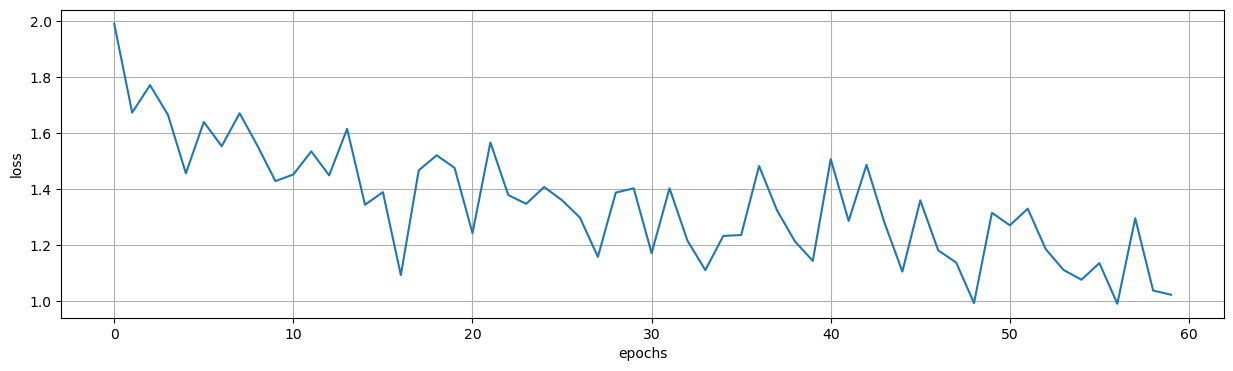

In [29]:
### Try different MLP models
# we can compare the loss change graph to under how the network parameters (such as number of layers and activation functions),
# could affect the performance of network.
input_data = train_data
output_data = train_label
nn = MLP([128,256,128,64,10], [None,'GELU','GELU','GELU','softmax'], [None,0.3,0.3,0.3,0.0],do_dropout = False, batch_norm= False, do_l2_norm = False)
CE_mini_batch = nn.fit_mini_batch(input_data, output_data, learning_rate=0.0001, momentum= 0.9 , epochs = 60, batch_size= 128)
print('loss:%f'%CE_mini_batch[-1])
pl.figure(figsize=(15,4))
pl.plot(CE_mini_batch)
pl.xlabel('epochs')
pl.ylabel('loss')
pl.grid()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

output = nn.predict(test_data)

output_train = nn.predict(train_data)

predicted_classes_train = np.argmax(output_train, axis = 1)
true_classes_train = np.argmax(train_label, axis = 1)
accuracy_train = np.mean(predicted_classes_train == true_classes_train)
print(f'Test Accuracy on train: {accuracy_train*100:.2f}%')


# 将预测概率转换为类别索引
predicted_classes = np.argmax(output, axis=1)
true_classes = np.argmax(test_label, axis=1)
print(predicted_classes[:30])
print(true_classes[:30])
# 计算准确率
accuracy = np.mean(predicted_classes == true_classes)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# 计算精确率、召回率和F1分数
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')


Test Accuracy on train: 60.06%
[0 8 0 0 6 6 5 6 7 1 8 9 5 7 9 8 5 7 8 6 7 2 2 9 4 2 6 4 1 6]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6]
Test Accuracy: 50.73%
Precision: 50.38%
Recall: 50.73%
F1 Score: 50.50%
